<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Прогнозирование-заказов-такси" data-toc-modified-id="Прогнозирование-заказов-такси-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Прогнозирование заказов такси</a></span><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li></ul></li></ul></div>

# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

## Постановка задачи

**Цель:**
 
Разработать модель, которая могла бы максимально точно прогнозировать спрос на такси.

**План работы:**
 
- Загрузить данные и выполнить их ресемплирование по одному часу
- Проанализировать данные
- Обучить разные модели с различными гиперпараметрами
- Проверить данные на тестовой выборке и сделать выводы

**Данные:** 
 
Данные предоставлены компанией "Четенькое такси". Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).




## Подготовка данных

In [16]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams, rcParamsDefault

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.metrics import make_scorer

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima 
from sklearn.model_selection import TimeSeriesSplit, cross_val_score



In [17]:
import warnings

warnings.filterwarnings('ignore')

In [18]:
RS = 12345

In [19]:
data = pd.read_csv('taxi.csv')

In [20]:
display(data.head(5))

datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32

In [21]:
print(data.shape)

(26496, 2)


In [22]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

In [23]:
data.duplicated().sum()

0

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [25]:
data['datetime'] = data['datetime'].astype('datetime64')

In [26]:
data = data.set_index('datetime')


In [27]:
#ресемплирование
data = data.resample('1H').sum()
display(data.head(5))

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

## Анализ данных

Text(0.5, 1.0, 'Orders each month')

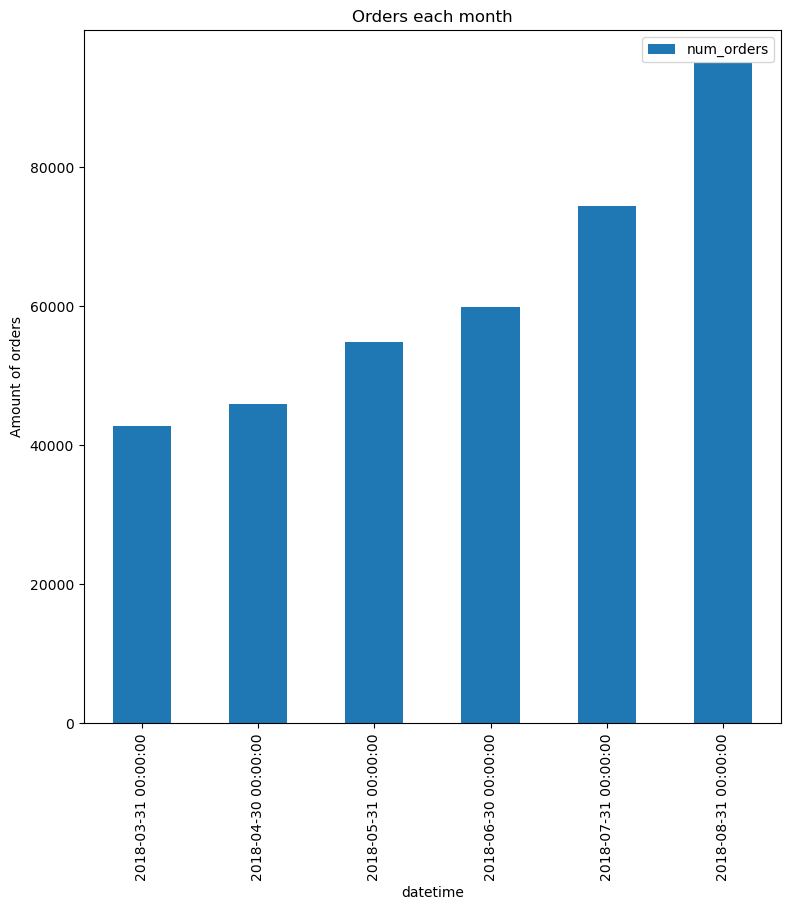

In [40]:
# посмотрим динамику в разные месяцы
data.resample('1M').sum().plot(kind='bar');
plt.ylabel("Amount of orders");
plt.title("Orders each month")

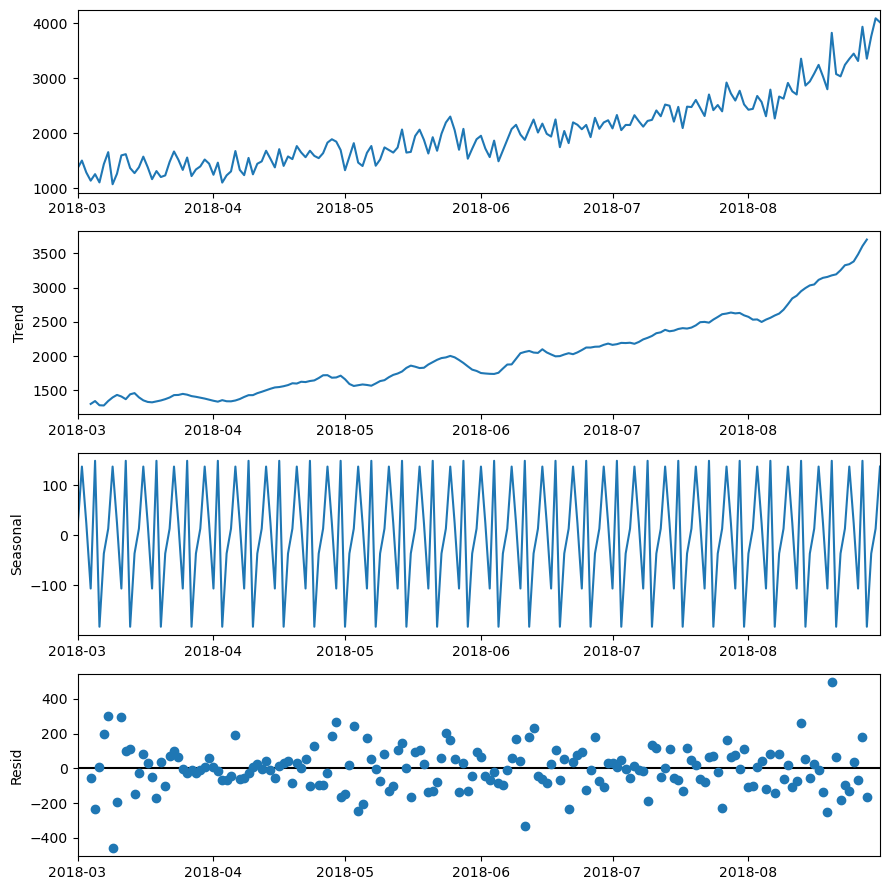

In [35]:
rcParams['figure.figsize'] = 9, 9
decompose = seasonal_decompose(data.resample('1D').sum())
decompose.plot()
plt.show()

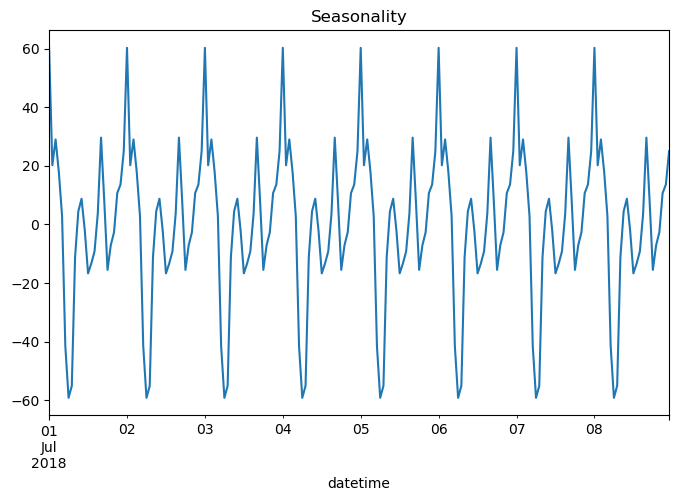

In [41]:
#сезонность на недельном отрезке
plt.figure(figsize=(8,5));
decompose_h = seasonal_decompose(data)
decomp_week = decompose_h.seasonal['2018-07-01':'2018-07-08']
decomp_week.plot()
plt.title("Seasonality")
plt.show()

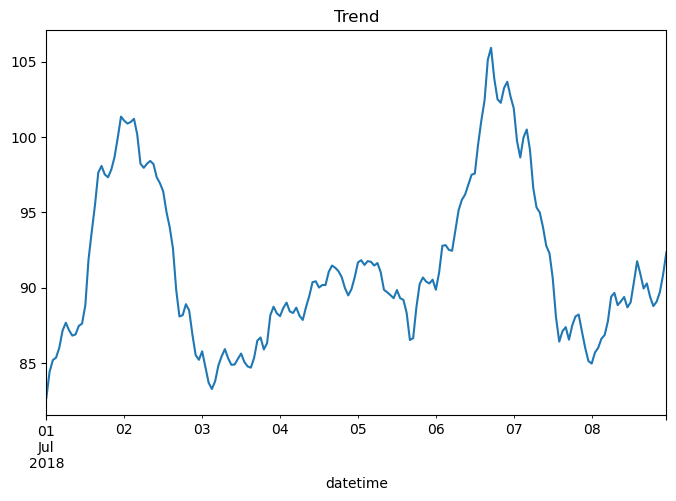

In [43]:
#тренд на недельном отрезке
plt.figure(figsize=(8,5));
decompose_h.trend['2018-07-01':'2018-07-08'].plot()
plt.title("Trend")
plt.show()

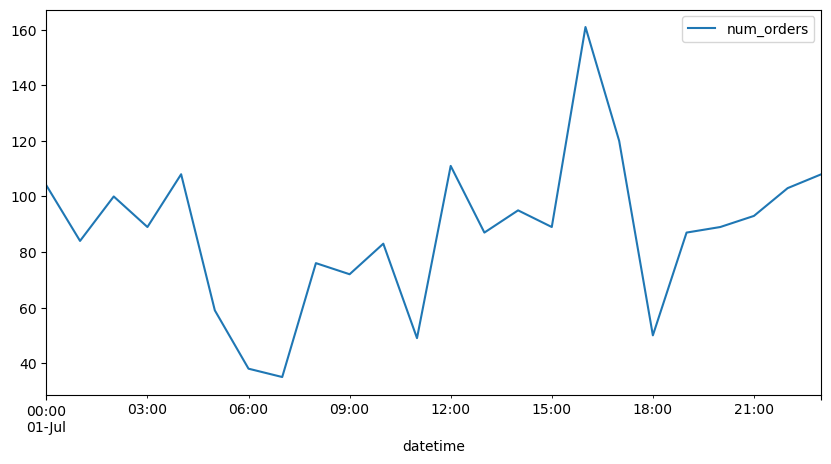

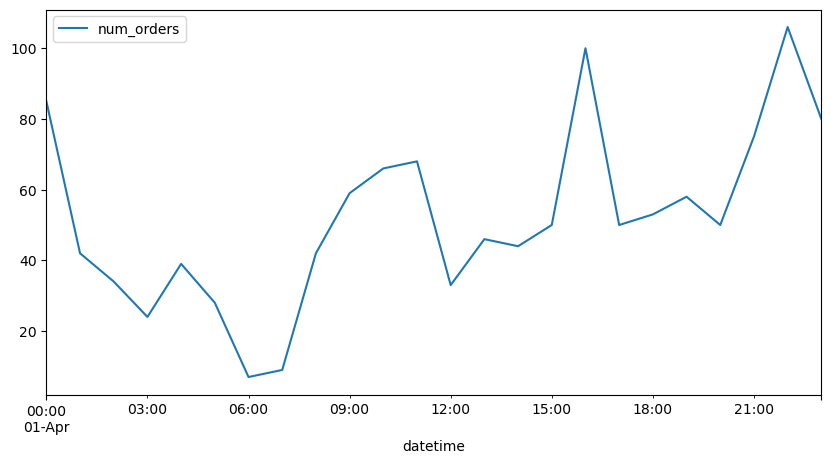

In [44]:
# Посмотрим, как выглядит один день в июле и один день в апреле
rcParams['figure.figsize'] = 10, 5
data['2018-07-01 00:00:00':'2018-07-01 23:00:00'].plot();
data['2018-04-01 00:00:00':'2018-04-01 23:00:00'].plot();


Можно заметить, что и в июле и в апреле есть резкое увеличение спроса в районе 18 часов. Я взяла именно июль и апрель, потому что в июле относительно высокий спрос, а в апреле не такой высокий. Можно оценить ситуацию и в туристические месяцы и в не очень туристические

In [17]:
# Исследуем стационарность 

adf_test = adfuller(data['num_orders'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.028940051402613506


Для более точной оценки стационарности можно применить тест Дики-Фуллера (Dickey-Fuller test). Нужно выполнить статистическую проверку гипотезы. В данном случае гипотезы звучат следующим образом.

- Нулевая гипотеза предполагает, что процесс нестационарный (существует единичный корень, ряд нестационарный)
- Альтернативная гипотеза соответственно говорит об обратном (единичного корня нет, ряд стационарный)

Используем пороговое значение, равное 0.05 (5%).

Можно считать, что ряд стационарен, соотвественно, никаких преобразований не нужно проводить

In [45]:
data_day = data['2018-07-01 00:00:00':'2018-07-02 23:00:00']
data_day

num_orders
datetime                       
2018-07-01 00:00:00         104
2018-07-01 01:00:00          84
2018-07-01 02:00:00         100
2018-07-01 03:00:00          89
2018-07-01 04:00:00         108
2018-07-01 05:00:00          59
2018-07-01 06:00:00          38
2018-07-01 07:00:00          35
2018-07-01 08:00:00          76
2018-07-01 09:00:00          72
2018-07-01 10:00:00          83
2018-07-01 11:00:00          49
2018-07-01 12:00:00         111
2018-07-01 13:00:00          87
2018-07-01 14:00:00          95
2018-07-01 15:00:00          89
2018-07-01 16:00:00         161
2018-07-01 17:00:00         120
2018-07-01 18:00:00          50
2018-07-01 19:00:00          87
2018-07-01 20:00:00          89
2018-07-01 21:00:00          93
2018-07-01 22:00:00         103
2018-07-01 23:00:00         108
2018-07-02 00:00:00         188
2018-07-02 01:00:00         147
2018-07-02 02:00:00         126
2018-07-02 03:00:00         148
2018-07-02 04:00:00         151
2018-07-02 05:00:00          37
2018-07-02 06:00:00          33
2018-07-02 07:00:00          31
2018-07-02 08:00:00         104
2018-07-02 09:00:00          84
2018-07-02 10:00:00         133
2018-07-02 11:00:00          66
2018-07-02 12:00:00          81
2018-07-02 13:00:00         108
2018-07-02 14:00:00          79
2018-07-02 15:00:00         115
2018-07-02 16:00:00          85
2018-07-02 17:00:00         103
2018-07-02 18:00:00          54
2018-07-02 19:00:00          96
2018-07-02 20:00:00          89
2018-07-02 21:00:00          83
2018-07-02 22:00:00          71
2018-07-02 23:00:00         121

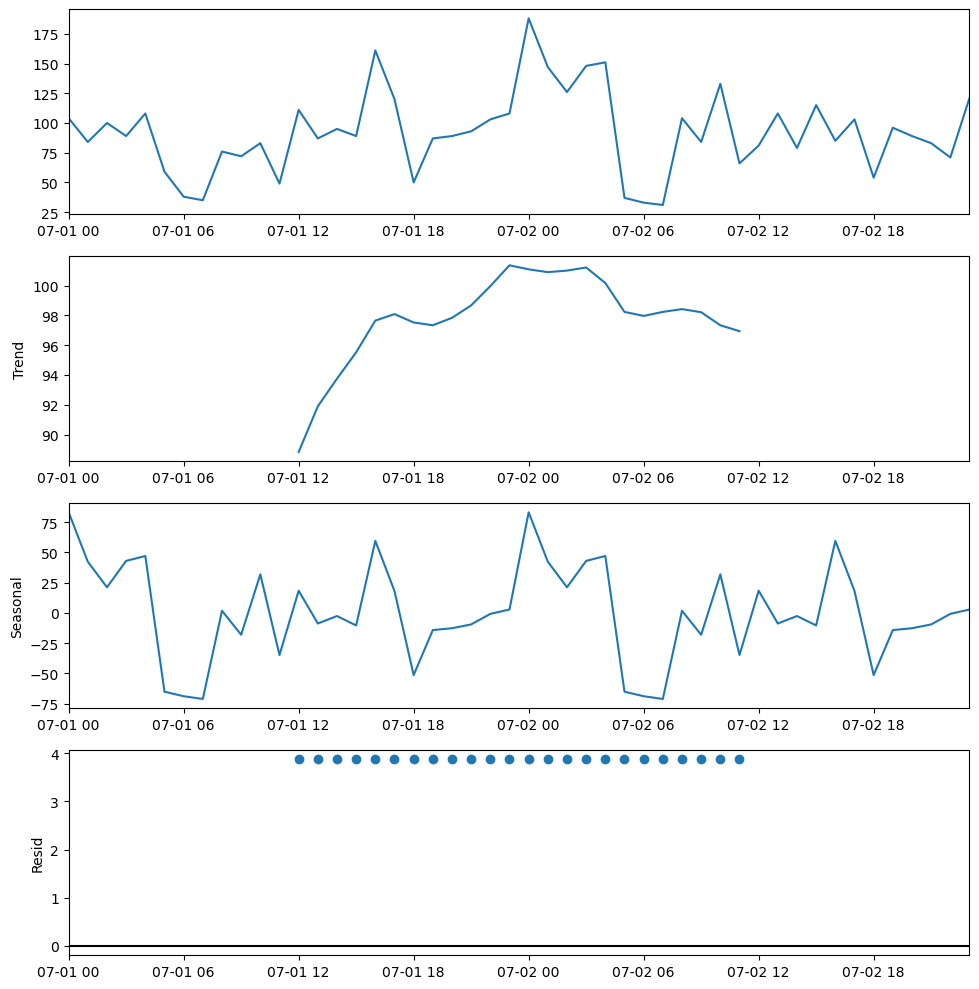

In [46]:
rcParams['figure.figsize'] = 10, 10
decompose_day = seasonal_decompose(data_day)
decompose_day.plot()
plt.show()

По тренду можно заметить ближе к вечеру (с 18 до 12 ночи) растет спрос и этот самое загруженное время для таксистов. По сезонности можно сказать, что утром в 6 утра резко падает спрос, затем возрастает ближе к 18 и 00.

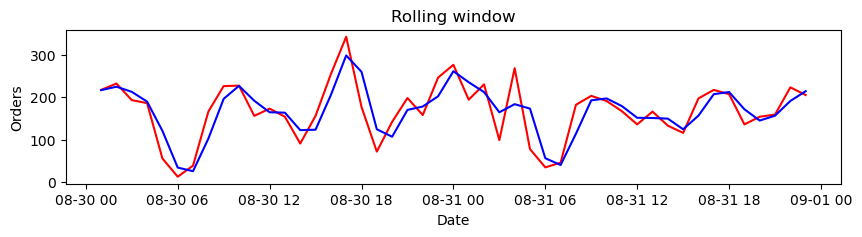

RMSE: 37.20937024517551


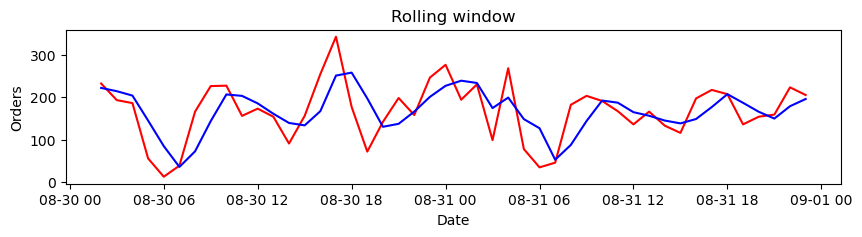

RMSE: 53.29049457074125


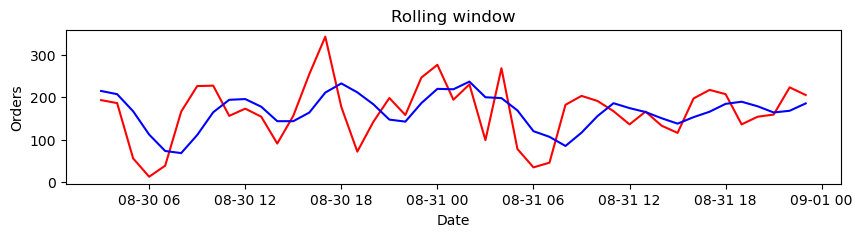

RMSE: 63.744498673306005


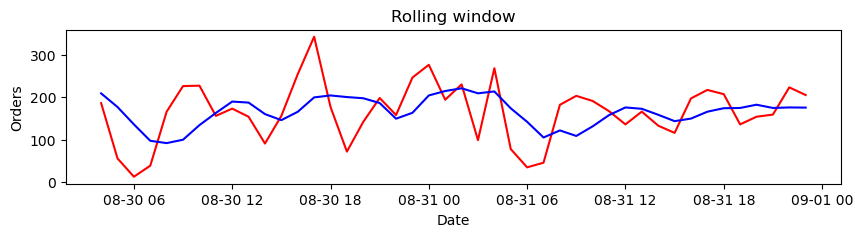

RMSE: 67.59614701230456


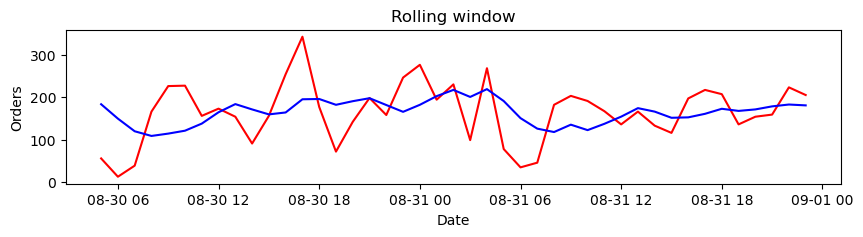

RMSE: 69.73090580801458


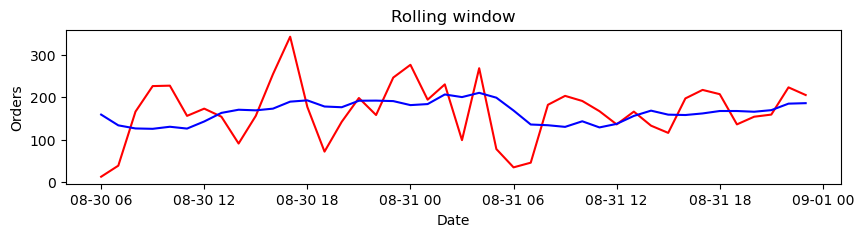

RMSE: 67.92390557450068


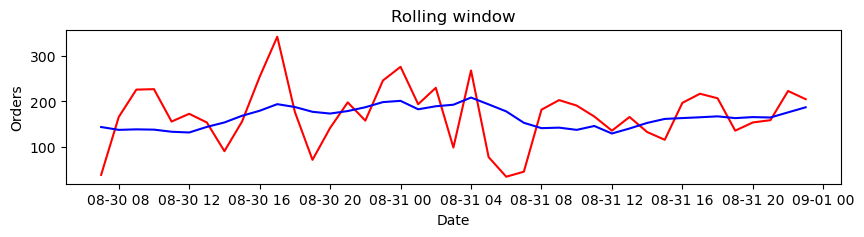

RMSE: 62.926871513977126


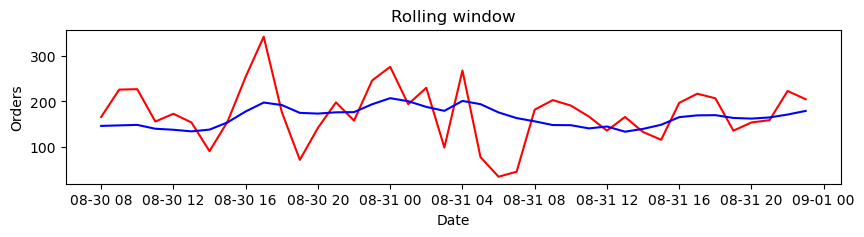

RMSE: 59.28822671627558


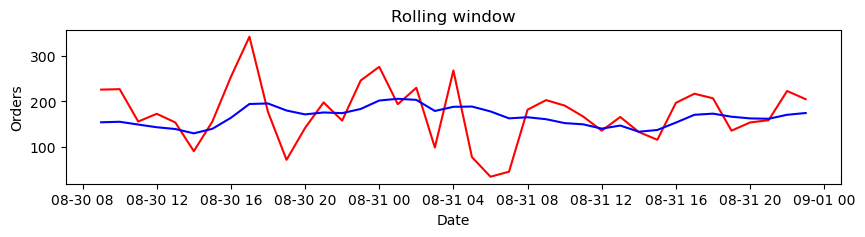

RMSE: 60.03829120033655


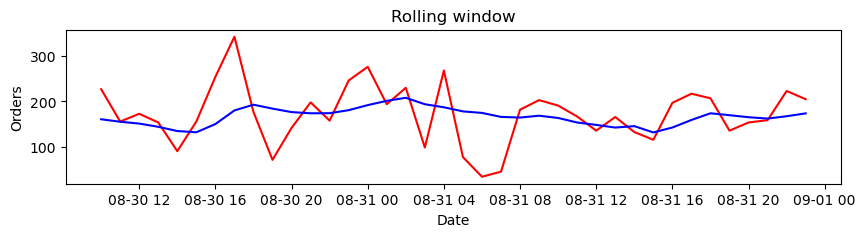

RMSE: 62.14800313100127


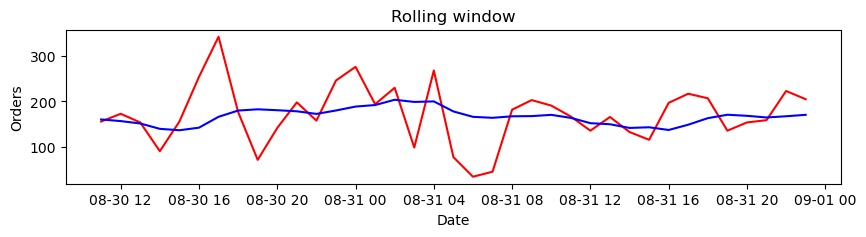

RMSE: 63.27369910554068


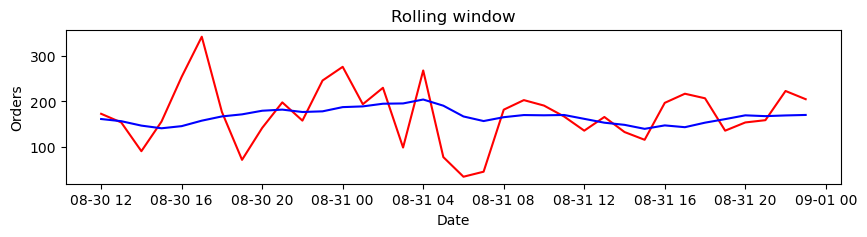

RMSE: 64.5242998632826


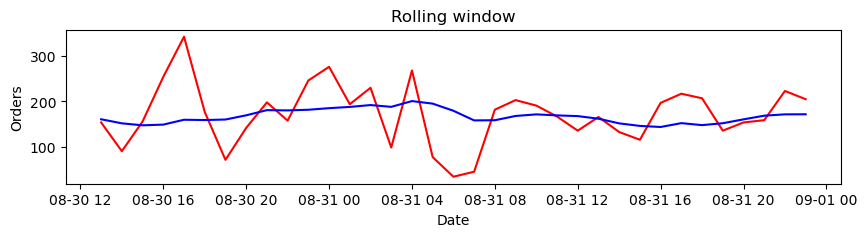

RMSE: 65.5193036785263


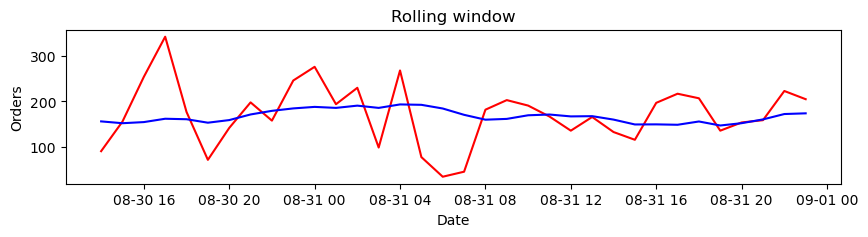

RMSE: 66.57033039492059


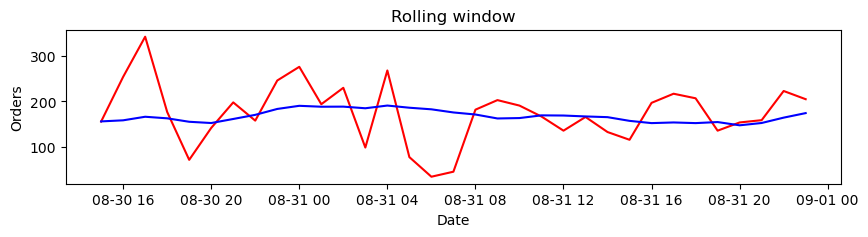

RMSE: 66.3901756391826


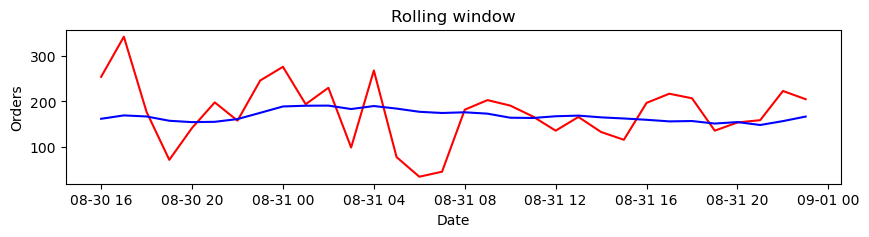

RMSE: 66.786833110948


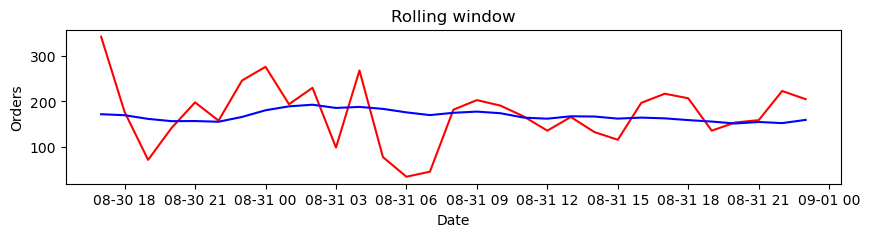

RMSE: 65.9555857159695


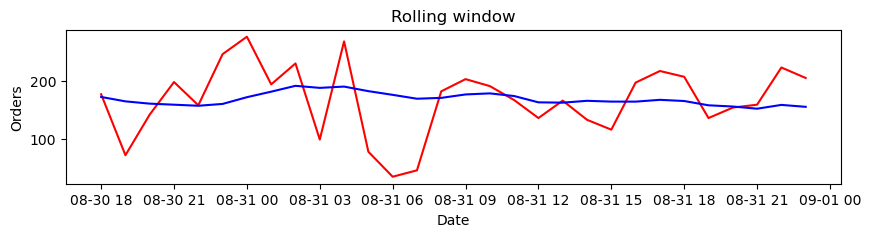

RMSE: 59.95063065843002


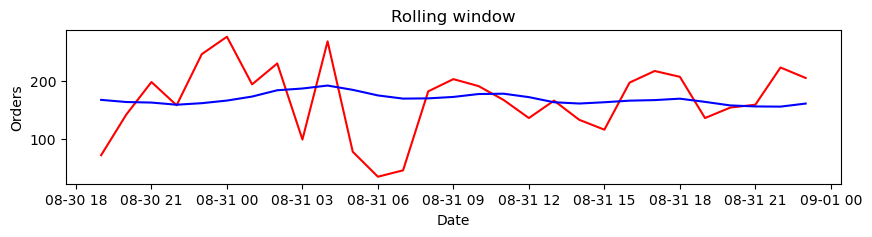

RMSE: 61.62310079608245


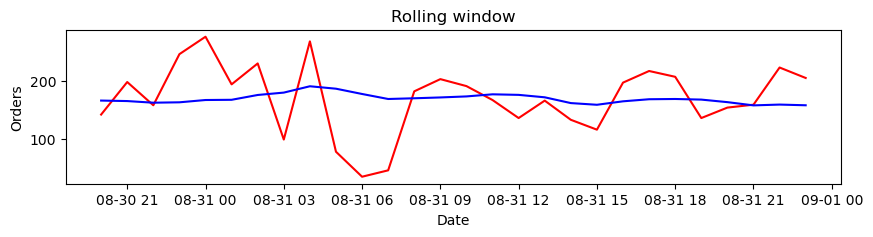

RMSE: 60.295350032185105


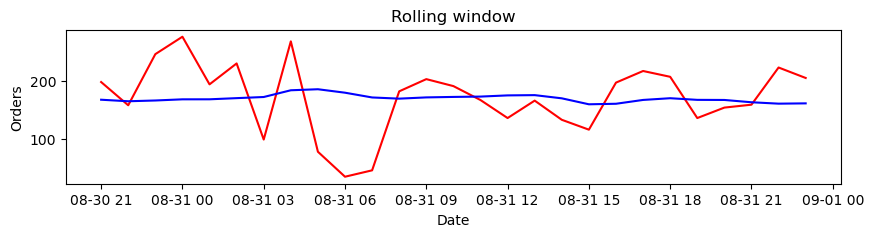

RMSE: 61.584824578009915


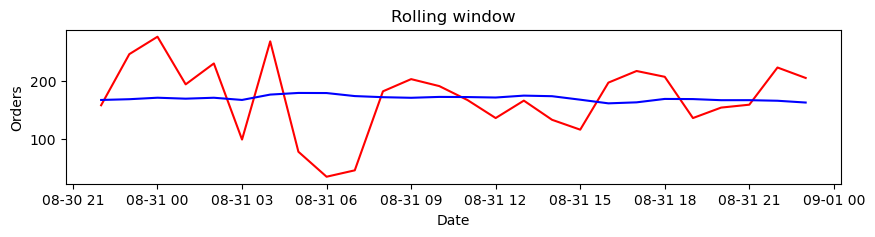

RMSE: 62.2411084136485


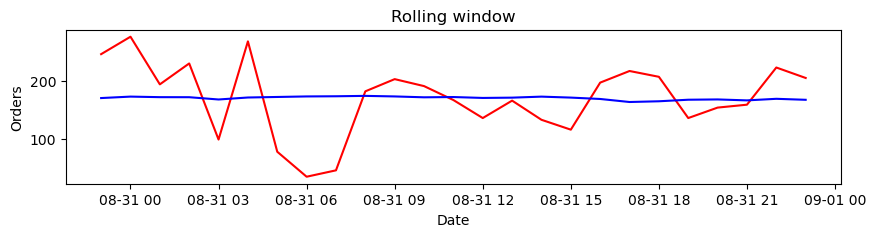

RMSE: 62.204006324173186


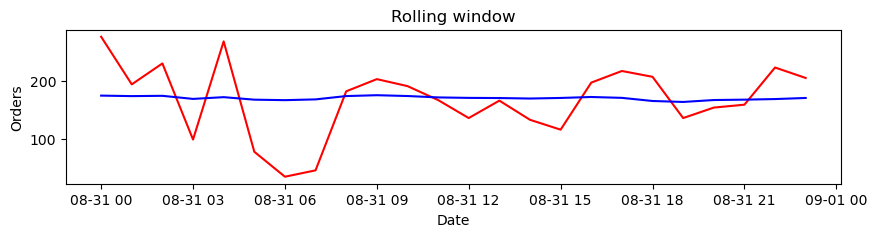

RMSE: 59.35472853951908


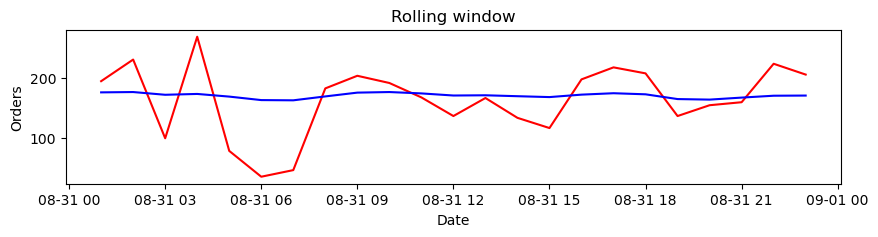

RMSE: 55.395072289503794


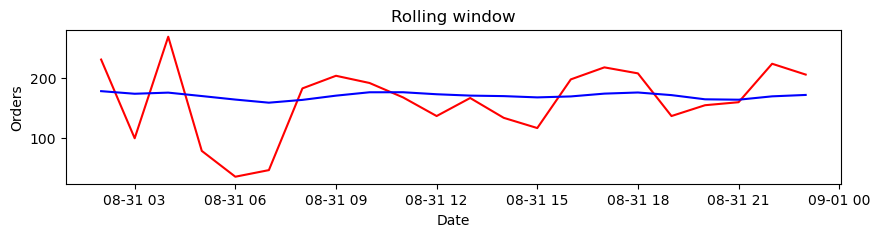

RMSE: 56.59878804647867


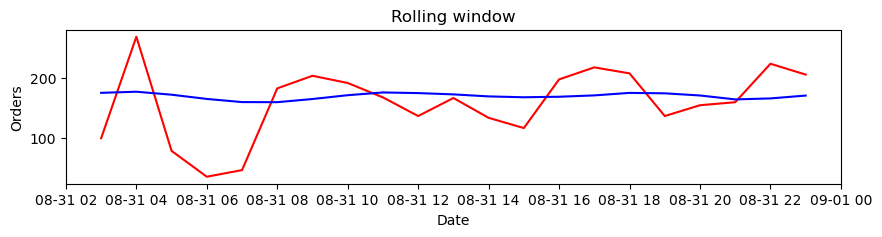

RMSE: 57.99764423770521


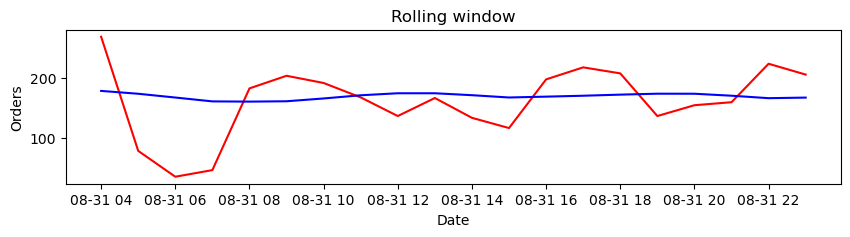

RMSE: 57.88077099016712


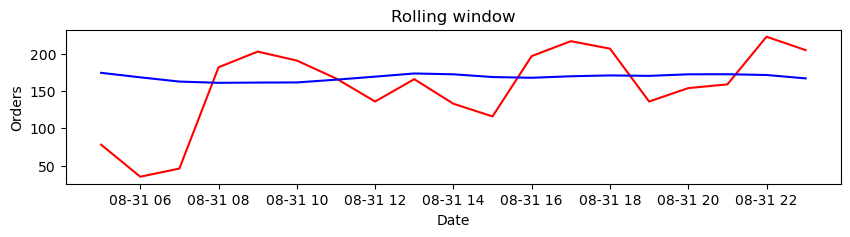

RMSE: 55.952374798698536


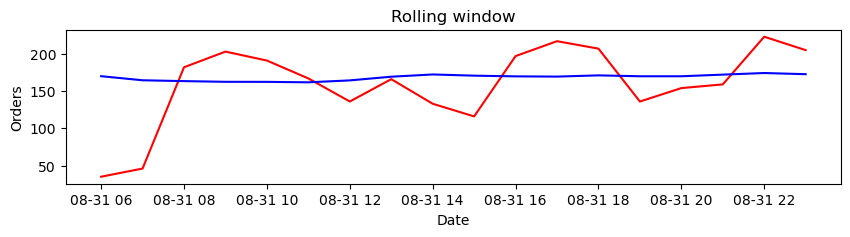

RMSE: 52.57135722880583


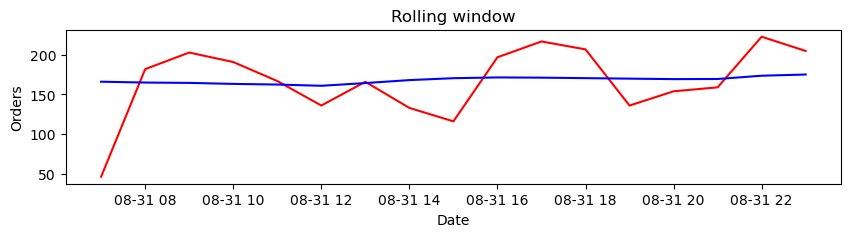

RMSE: 42.49692354782181


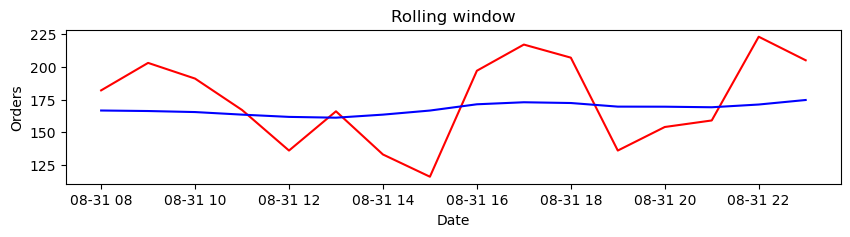

RMSE: 30.931430392629238


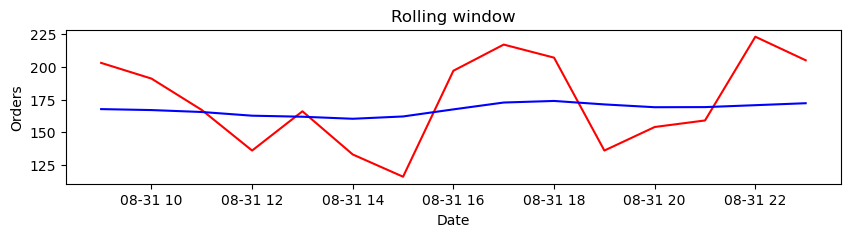

RMSE: 31.350481822389316


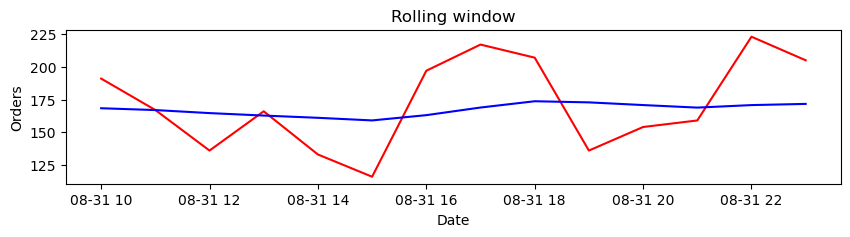

RMSE: 31.774131803954045


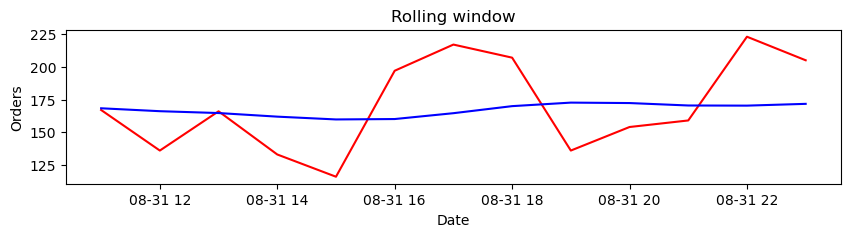

RMSE: 33.78557444177727


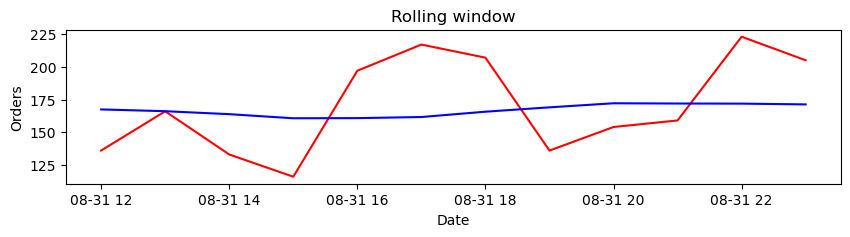

RMSE: 35.77340048315332


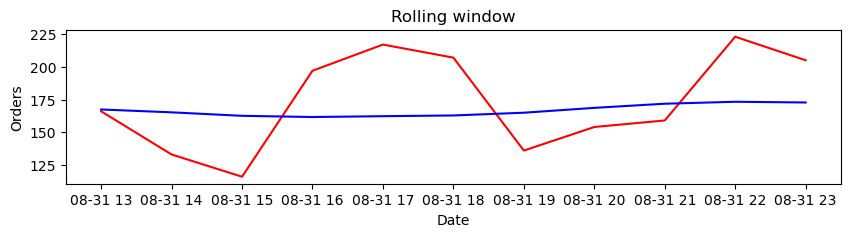

RMSE: 35.84313191905542


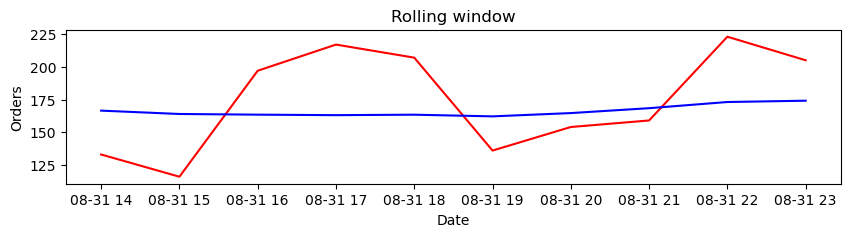

RMSE: 36.996836050019624


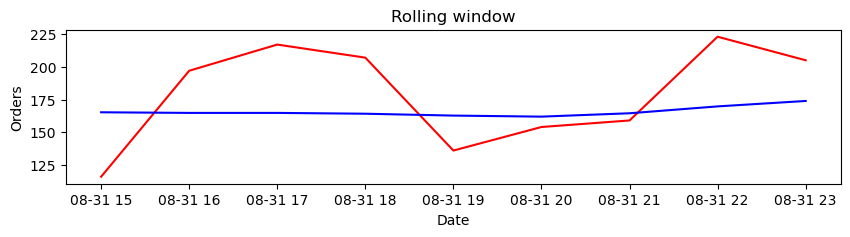

RMSE: 37.472419487167116


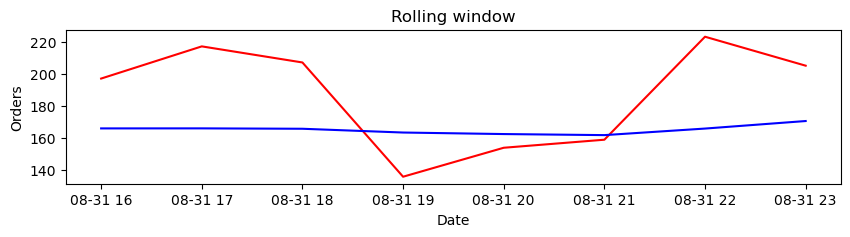

RMSE: 36.27573037059744


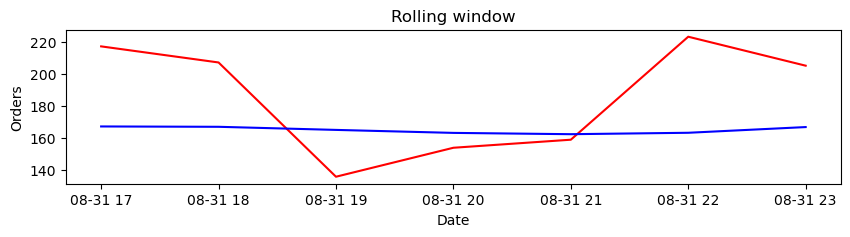

RMSE: 37.86404976996232


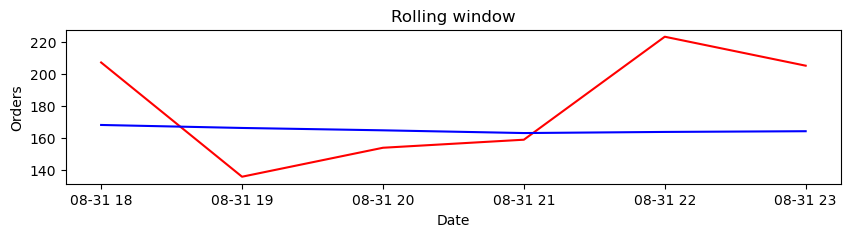

RMSE: 35.86913849604602


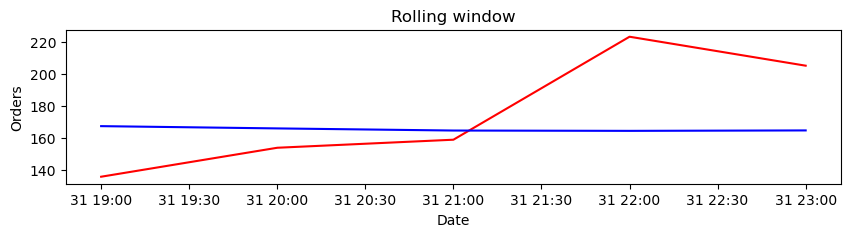

RMSE: 35.22933571671942


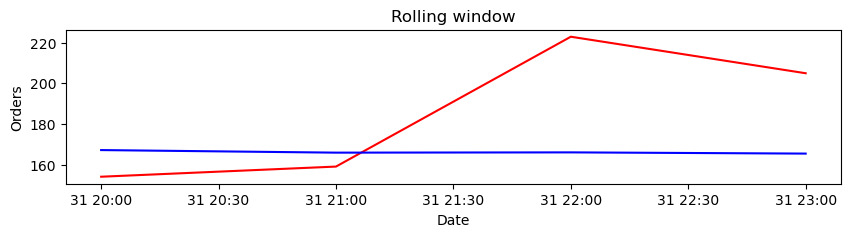

RMSE: 35.48519252996789


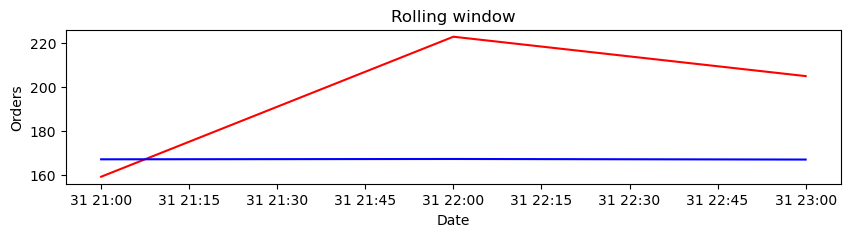

RMSE: 39.339261618971676


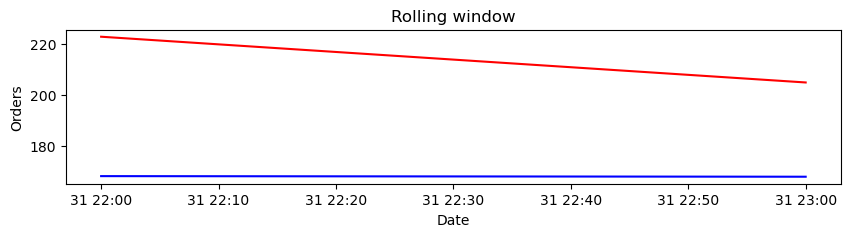

RMSE: 46.818502318507804


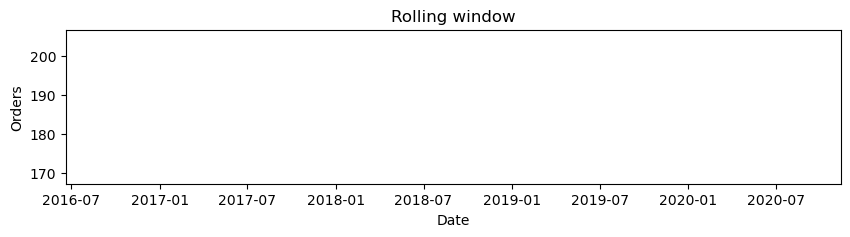

RMSE: 36.08333333333334


In [92]:
rcParams['figure.figsize'] = 10,2
rolling_mean_size_dict = {}
for rolling_mean_size in range(2,49):
    data_aug = data['2018-08-30':'2018-08-31'].copy()
    data_aug['rolling_mean'] = data_aug['num_orders'].rolling(rolling_mean_size).mean()
    data_aug.dropna(inplace=True)
    index = data_aug.index
    num_orders = data_aug['num_orders']
    rolling_mean = data_aug['rolling_mean']
    plt.plot(index,num_orders,'r-',index, rolling_mean,'b-')
    plt.title("Rolling window")
    plt.xlabel("Date")
    plt.ylabel("Orders")
    plt.show()
    RMSE = mean_squared_error(num_orders,rolling_mean)**0.5
    print('RMSE:', RMSE)
    rolling_mean_size_dict[rolling_mean_size] = RMSE

In [21]:
rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

33

In [71]:
max_lag = 20

In [68]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [69]:
data_w_feat = data.copy()

In [72]:
make_features(data_w_feat,'num_orders', max_lag, rolling_mean_size)

In [73]:
data_w_feat = data_w_feat.dropna()

In [74]:
data_w_feat

num_orders  day  dayofweek  month  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-03 00:00:00         163    3          5      3   72.0  119.0  101.0   
2018-03-03 01:00:00         108    3          5      3  163.0   72.0  119.0   
2018-03-03 02:00:00          25    3          5      3  108.0  163.0   72.0   
2018-03-03 03:00:00          64    3          5      3   25.0  108.0  163.0   
2018-03-03 04:00:00          44    3          5      3   64.0   25.0  108.0   
...                         ...  ...        ...    ...    ...    ...    ...   
2018-08-31 19:00:00         136   31          4      8  207.0  217.0  197.0   
2018-08-31 20:00:00         154   31          4      8  136.0  207.0  217.0   
2018-08-31 21:00:00         159   31          4      8  154.0  136.0  207.0   
2018-08-31 22:00:00         223   31          4      8  159.0  154.0  136.0   
2018-08-31 23:00:00         205   31          4      8  223.0  159.0  154.0   

                     lag_4  lag_5  lag_6  ...  lag_12  lag_13  lag_14  lag_15  \
datetime                                  ...                                   
2018-03-03 00:00:00   93.0   49.0   89.0  ...    36.0    91.0    54.0    45.0   
2018-03-03 01:00:00  101.0   93.0   49.0  ...    45.0    36.0    91.0    54.0   
2018-03-03 02:00:00  119.0  101.0   93.0  ...    44.0    45.0    36.0    91.0   
2018-03-03 03:00:00   72.0  119.0  101.0  ...    59.0    44.0    45.0    36.0   
2018-03-03 04:00:00  163.0   72.0  119.0  ...    82.0    59.0    44.0    45.0   
...                    ...    ...    ...  ...     ...     ...     ...     ...   
2018-08-31 19:00:00  116.0  133.0  166.0  ...    46.0    35.0    78.0   268.0   
2018-08-31 20:00:00  197.0  116.0  133.0  ...   182.0    46.0    35.0    78.0   
2018-08-31 21:00:00  217.0  197.0  116.0  ...   203.0   182.0    46.0    35.0   
2018-08-31 22:00:00  207.0  217.0  197.0  ...   191.0   203.0   182.0    46.0   
2018-08-31 23:00:00  136.0  207.0  217.0  ...   167.0   191.0   203.0   182.0   

                     lag_16  lag_17  lag_18  lag_19  lag_20  rolling_mean  
datetime                                                                   
2018-03-03 00:00:00    46.0     7.0    11.0    11.0    20.0     59.791667  
2018-03-03 01:00:00    45.0    46.0     7.0    11.0    11.0     60.604167  
2018-03-03 02:00:00    54.0    45.0    46.0     7.0    11.0     61.083333  
2018-03-03 03:00:00    91.0    54.0    45.0    46.0     7.0     60.125000  
2018-03-03 04:00:00    36.0    91.0    54.0    45.0    46.0     60.083333  
...                     ...     ...     ...     ...     ...           ...  
2018-08-31 19:00:00    99.0   230.0   194.0   276.0   246.0    170.895833  
2018-08-31 20:00:00   268.0    99.0   230.0   194.0   276.0    170.208333  
2018-08-31 21:00:00    78.0   268.0    99.0   230.0   194.0    169.437500  
2018-08-31 22:00:00    35.0    78.0   268.0    99.0   230.0    169.208333  
2018-08-31 23:00:00    46.0    35.0    78.0   268.0    99.0    170.166667  

[4368 rows x 25 columns]

## Обучение моделей

In [51]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [52]:
rmse_scorer = make_scorer(rmse,greater_is_better=False)

In [53]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [54]:
train = train.dropna()

In [55]:
model = auto_arima(y = train, m=24)

In [56]:
predictions = pd.Series(model.predict(n_periods = 442))
predictions

2018-08-13 14:00:00    114.411423
2018-08-13 15:00:00    145.244013
2018-08-13 16:00:00    149.312266
2018-08-13 17:00:00    125.423515
2018-08-13 18:00:00     98.926245
                          ...    
2018-08-31 19:00:00    134.086303
2018-08-31 20:00:00    134.086791
2018-08-31 21:00:00    134.087879
2018-08-31 22:00:00    134.087396
2018-08-31 23:00:00    134.089304
Freq: H, Length: 442, dtype: float64

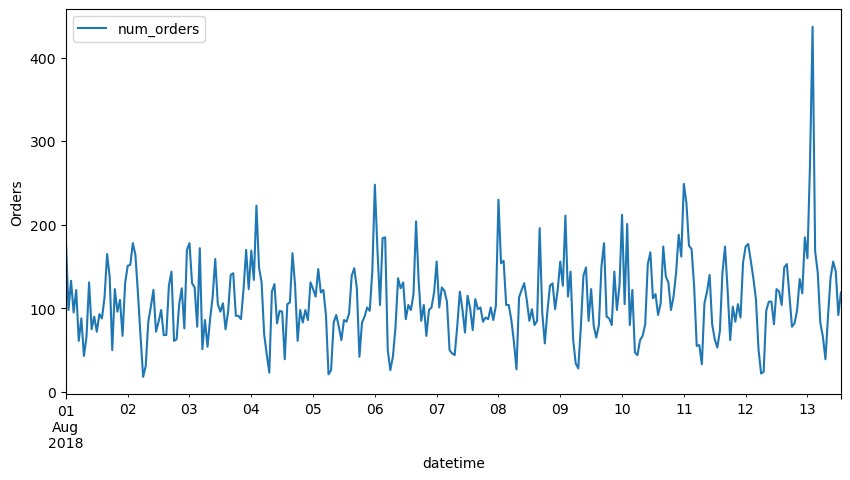

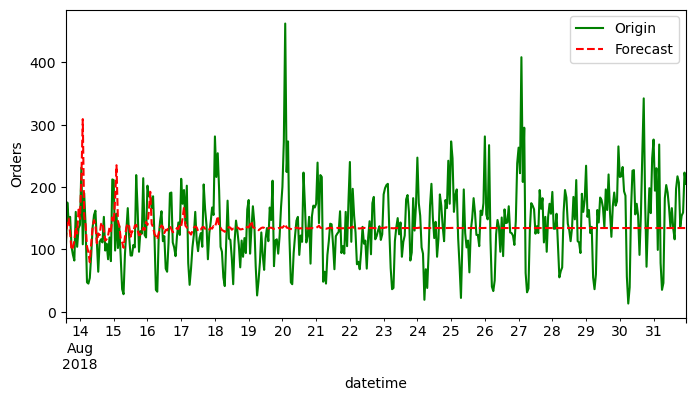

In [61]:
rcParams['figure.figsize'] = 10,5
train['2018-08'].plot(label='Original')
plt.ylabel("Orders")
test.plot(label='Test', color='green')
predictions.plot(label='Forecast', figsize=(8,4), style='--', color='red')
plt.legend(['Origin', 'Forecast' ])
plt.ylabel("Orders")
plt.show;

In [62]:
test

num_orders
datetime                       
2018-08-13 14:00:00         102
2018-08-13 15:00:00         175
2018-08-13 16:00:00         144
2018-08-13 17:00:00         152
2018-08-13 18:00:00         104
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[442 rows x 1 columns]

In [63]:
mean_squared_error(test, predictions, squared=False)

57.87611358614489

In [77]:
train, test = train_test_split(data_w_feat, shuffle=False, test_size=0.1)

In [78]:
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']

X_test = test.drop(columns='num_orders')
y_test = test['num_orders']



In [82]:
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=5)
# RandomForest
RF = RandomForestRegressor(random_state=RS)
parametrs = {"max_depth": range(5,25),"n_estimators":range(10,50)}

RF_grid = RandomizedSearchCV(RF,parametrs,cv = splits,verbose=True,scoring=rmse_scorer,n_jobs=-1)
RF_grid.fit(X_train,y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(5, 25),
                                        'n_estimators': range(10, 50)},
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=True)

In [83]:
# CatBoost
catboost = CatBoostRegressor(random_state = RS)
params_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
cat_grid = RandomizedSearchCV(catboost, params_cat, cv=splits,verbose=True,scoring=rmse_scorer)

In [84]:
cat_grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 28.5906999	total: 66.1ms	remaining: 1m 5s
1:	learn: 27.6602053	total: 67.1ms	remaining: 33.5s
2:	learn: 26.7155466	total: 68.2ms	remaining: 22.7s
3:	learn: 26.0005531	total: 69.1ms	remaining: 17.2s
4:	learn: 25.2721577	total: 70ms	remaining: 13.9s
5:	learn: 24.6416148	total: 70.8ms	remaining: 11.7s
6:	learn: 23.9825558	total: 71.7ms	remaining: 10.2s
7:	learn: 23.3570587	total: 72.6ms	remaining: 9.01s
8:	learn: 22.8135852	total: 73.5ms	remaining: 8.1s
9:	learn: 22.3918315	total: 74.5ms	remaining: 7.38s
10:	learn: 22.0100693	total: 75.4ms	remaining: 6.78s
11:	learn: 21.7316849	total: 76.5ms	remaining: 6.29s
12:	learn: 21.3952146	total: 77.4ms	remaining: 5.88s
13:	learn: 21.0632931	total: 78.4ms	remaining: 5.52s
14:	learn: 20.7161819	total: 79.3ms	remaining: 5.21s
15:	learn: 20.4865783	total: 80.2ms	remaining: 4.93s
16:	learn: 20.2538717	total: 81.2ms	remaining: 4.69s
17:	learn: 20.0435563	total: 82.1ms	remaining: 4.48

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7fe6f3eb1bd0>,
                   param_distributions={'depth': [5, 10],
                                        'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=True)

In [42]:
RF_grid.best_score_*(-1)

28.559483282880166

In [43]:
model_RF = RF_grid.best_estimator_

In [44]:
grid_res = pd.DataFrame(RF_grid.cv_results_).sort_values(by='rank_test_score')

In [45]:
grid_res.iloc[0]['mean_fit_time'], grid_res.iloc[0]['mean_score_time']

(3.839567232131958, 0.028436565399169923)

In [46]:
cat_grid.best_score_*(-1)


27.766547308854133

In [86]:
model_CB = cat_grid.best_estimator_

In [87]:
grid_res = pd.DataFrame(cat_grid.cv_results_).sort_values(by='rank_test_score')

In [88]:
grid_res.iloc[0]['mean_fit_time'], grid_res.iloc[0]['mean_score_time']

(1.6253747940063477, 0.005122995376586914)

Тк показатели у CB лучше протестируем ее еще и на тестовых данных.

In [89]:
predicted = model_CB.predict(X_test)
score = rmse(predicted, y_test)
print(score)

47.45735806019267


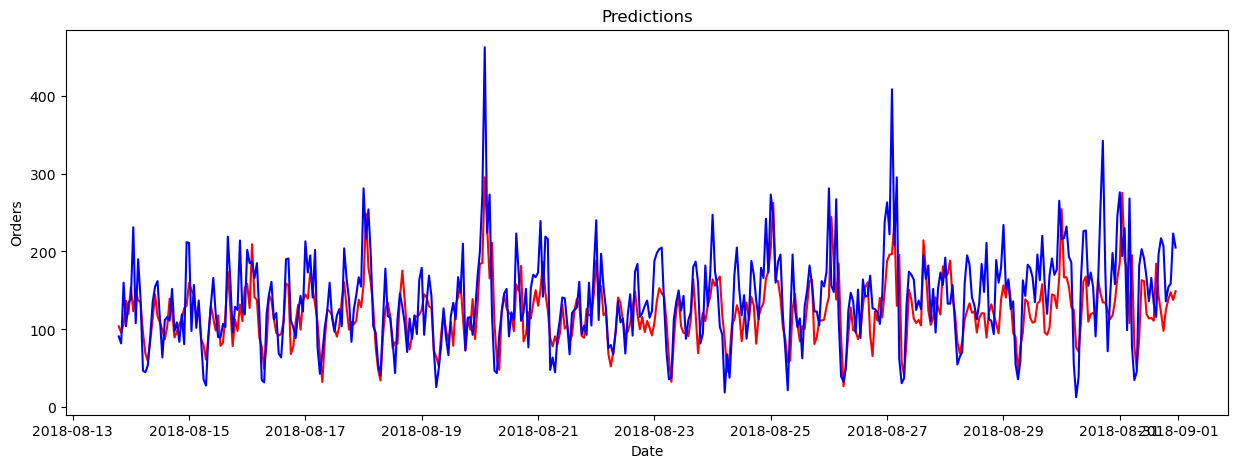

In [90]:
plt.subplots(figsize=(15, 5))
x=y_test.index
y1=predicted
y2=y_test
plt.plot(x, y1, color='red')
plt.plot(x, y2, color='blue')
plt.title("Predictions")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.show()

## Выбор лучшей модели

**Вывод:** Самой подходящей моделью для нашей задачи оказалась catboost. Ее метрика меньше 48, она быстро обучается.